# Tutorial 2. Analysis tools (LPATH)
Author: Jeremy Leung<br>
Email:&nbsp;&nbsp; jml230@pitt.edu

## Introduction

This document is a companion jupyter notebook for the LPATH section of the second tutorial in the 2024 WESTPA workshop. It involves running a pathway analysis on a SynD-based simulation of NTL9 protein folding using LPATH. Upon completion of this tutorial, a user should be able to analyze any simulation with LPATH.

Feel free to pull up the help menu with ``--help`` at any point (e.g., ``lpath extract --help``). While currently broken (waiting for upstream fix), you can also install a TUI (terminal user interface) for LPATH to help with the many options.

LPATH Paper: https://pubs.acs.org/doi/full/10.1021/acs.jcim.3c01318<br>
GitHub Repository: https://github.com/chonglab-pitt/LPATH<br>
Example Files: https://github.com/chonglab-pitt/LPATH/tree/main/examples


## 1. Learning Objectives


* How to use LPATH pathway analysis to cluster pathways


## 2. System Requirements

- WESTPA >=2022.10 and LPATH >=1.0.3 (Under ``lpath-md`` on PyPI) are needed.
- All of these programs are available in the shared environment for the WESTPA workshop.

## 3. Introduction

An introduction to LPATH. Also read this section to setup this notebook.

The pathways by which a molecular process transitions to a target state are highly sought-after as direct views of a transition mechanism. While great strides have been made in the physics-based simulation of such pathways, the analysis of these pathways can be a major challenge due to their diversity and variable lengths. The LPATH Python tool is a semi-automated method for linguistics-assisted clustering of pathways into distinct classes (or routes). This method involves three steps:
1) discretizing the configurational space into key states,
2) extracting a text-string sequence of key visited states for each pathway, and
3) pairwise matching of pathways based on a text-string similarity score.

In this notebook, you'll see two subsections in each step: ``Command Line`` and ``Python``. These are two different ways of calling the same command. You will only need to run one or the other.

### Setting up the Notebook

Run this section to setup this notebook.

#### Default Setup

If you're here during the workshop, we assumed you already have an environment set up. Just make sure your kernel says ``westpa-workshop2024`` (top left corner, next to ⃝).

If you're using this notebook on your own, you can create a working environment with the ``env.yaml`` file via ``conda env create -f env.yaml``. If you prefer pip, you can also install all needed packages with the command ``python -m pip install -r ../ntl9_sample_files/requirements.txt``.

#### Google CoLab

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
!pip install -q -q -q lpath-md scikit-learn westpa synd # -q -q -q is used to silent the installation process.
!git clone --quiet https://github.com/jeremyleung521/westpa-workshop2024-tutorials
%cd /content/westpa-workshop2024-tutorials/tutorial2b-lpath

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 686.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 9.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.9 MB/s eta 0:00:00
/content/westpa-workshop2024-tutorials/tutorial2b-lpath


## 4. Discretization


In this step, source and target states are defined, and (optionally) the regions of configuration space between these states are subdivided into discrete states. We will run the discretization with ``w_assign`` (called through ``lpath discretize``).

### Command line

In [ ]:
# Note that ``PATH="$HOME/.local/bin:$PATH"`` is added because we are running bash within a jupyter notebook. 
# In most cases, running ``lpath`` directly should work

! PATH="$HOME/.local/bin:$PATH" lpath discretize -we -W ./west.h5 --assign-arguments "--config-from-file --scheme CRUDE_RMSD"
# -we : Running in "weighted ensemble" mode
# -W : Our west.h5 file name (which is west.h5)
# --assign-arguments : Command line arguments to be passed to w_assign
# --config-from-file : Read from configuration file (default: west.cfg)
# --scheme : The scheme we're using to discretize states, as specified in the config file (i.e., west.cfg)

### Python

In [3]:
from lpath import discretize
from argparse import Namespace

# All the arguments
discrete_args = Namespace(we=True,
                          input_name='west.h5',
                          west_name='west.h5',
                          extract_input='./ANALYSIS/CRUDE_RMSD/assign.h5',
                          assign_name='./ANALYSIS/CRUDE_RMSD/assign.h5',
                          rcfile='west.cfg',
                          assign_args=Namespace(  # These are arguments for w_assign
                                                verbosity='verbose',  # Verbose or debug
                                                rcfile='west.cfg',  # west.cfg
                                                we_h5filename='west.h5',  # west.h5 path
                                                construct_dataset=None,  # If you need some custom auxiliary dataset
                                                output='assign.h5',  # Output file
                                                config_from_file=True,  # Read config from rcfile
                                                scheme='CRUDE_RMSD',  # Scheme name
                                                max_queue_length=None,  # Other WESTPA-related things, need to be included, but safe to ignore
                                                subsample=None,
                                                dsspecs=None,
                                                  )
                          )

# Running it.
discretize.main(discrete_args)
# Little-to-no Output is good.

Initializing...
Scanning for segment and point counts...
Preparing output...
Assigning to bins...


## Extract

In this step, all trajectories connecting the source and target states are traced out into a pickle object. This step is parallelized with ray.

We will need to inform LPATH which bin(s) are the start starting state, and  which bin(s) are the target state. This is typically in the order specified in west.cfg (or what was passed into ``w_assign`` or ``lpath discretize``).

#### Command Line

In [ ]:
# Note that ``PATH="$HOME/.local/bin:$PATH"`` is added because we are running bash within a jupyter notebook. 
# In most cases, running ``lpath`` directly should work

! PATH="$HOME/.local/bin:$PATH" lpath extract -we -W ./west.h5 -A ./ANALYSIS/CRUDE_RMSD/assign.h5 -ss 1 -ts 0 -p --aux sasa --stride 10
# -we : Running in "weighted ensemble" mode
# -W : Our west.h5 file name (which is west.h5)
# -A : The analysis file generated by w_assign
# -ss : Starting state index, typically in the order which you specified your states in west.cfg
# -ts : Target state index, typically in the order which you specified your states in west.cfg
# -p : Include the Progress Coordinate in the output pickle object
# --aux : Include the "sasa" aux dataset in the output pickle object
# --stride : Use N frames from each WE "tau" segment. Because we saved 11 frames each WE tau (one for the parent trajectory), we will use all of our data.
# Note the `--stride` option works differently if you run it on a standard simulation.

#### Python

In [ ]:
from lpath import extract
from argparse import Namespace
import os

# Since we're bypassing the command line argparse, we need to make our output directory 'succ_traj' manually
try:
    os.mkdir('succ_traj')
except FileExistsError:
    pass

# All the arguments
extract_args = Namespace(debug=False,
                         we=True,
                         out_dir='succ_traj',
                         stride=10,
                         west_name='./west.h5',
                         rc_file='west.cfg',
                         extract_input='states.npy',
                         extract_output='succ_traj/output.pickle',
                         assign_name='./ANALYSIS/CRUDE_RMSD/assign.h5',
                         source_state_num=1,
                         target_state_num=0,
                         pcoord=True,
                         featurization_name=None,
                         feature_stride=1,
                         trace_basis=False,
                         exclude_short=0,
                         use_ray=True,
                         threads=0,
                         first_iter=1,
                         last_iter=0,
                         stats=True,
                         hdf5=False, auxdata=None, rewrite_weights=False, out_traj=False, out_traj_ext='.nc', out_state_ext='.ncrst', out_top='system.prmtop',
                         )

# Running it
extract.main(extract_args)

## Match

In this step, we compare all of the successful trajectories from the "extract" step. These pathways are first transformed into a string representing the discrete states. Then, we will use hierarchical clustering to separate these pathways into distinct classes.

For example if a trajectory went through states 0 --> 1 --> 2 --> 1 --> 3 and our dictionary maps 0,1,2,3 to A,B,C,D, then the trajectory could be represented as string 'ABCBD'.

### Using just the Pcoord (CA-RMSD)

As a first step, we will run LPATH matching only with CA-RMSD.

#### Command Line

In [ ]:
# Note that ``PATH="$HOME/.local/bin:$PATH"`` is added because we are running bash within a jupyter notebook. 
# In most cases, running ``lpath`` directly should work

! PATH="$HOME/.local/bin:$PATH" lpath match --condense 2 --plots-hide --n-clusters 2 --timeout 0 --stats
# --condense : Any states that repeat N times in a row are condensed into a single instance (e.g., AABBAA will turn into ABA)
# --plots-hide : Do not show plots (dendrogram)
# --n-clusters : The numbers of clusters to divide the pathways into. LPATH will ask you questions interactively.
# --timeout : How long to wait for prompts. 0 completely skips the prompts.
# --stats : Show Matching statistics

In [ ]:
!ls succ_traj

In [ ]:
from IPython.display import IFrame, display
filepath = "plots/dendroram.pdf"
IFrame(filepath, width=700, height=400)

#### Python

  0%|          | 0/1482 [00:00<?, ?it/s]

Do you want to regenerate the graph with a new threshold (y/[n])?
lpath.match — INFO — 
===LPATH Pattern Matching Statistics===
   Total Number of clusters: 3
   Weight/count/unique count of cluster 0: 4.70753733e-03 / 39 / N/A
   Weight/count/unique count of cluster 1: 0.00000000e+00 / 0 / N/A
   Weight/count/unique count of cluster 2: 0.00000000e+00 / 0 / N/A

lpath.match — INFO — Outputting files
lpath.match — INFO — cluster 0 representative weight: [20.0 8.0 0.0 0.9811999797821045 3049.9984328125 8.0 0.0005918560606060604]


/usr/local/lib/python3.10/dist-packages/scipy/cluster/hierarchy.py:2844: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0, dvw])


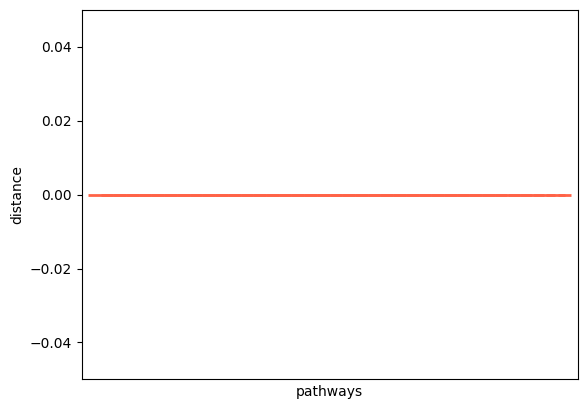

In [ ]:
from lpath import match
from argparse import Namespace
import os

# Since we're bypassing the command line argparse, we need to make our output directory 'plots' manually
try:
    os.mkdir('plots')
except FileExistsError:
    pass

# All the arguments
match_args = Namespace(debug=False,
                       we=True,
                       stats=True,
                       out_dir='succ_traj',
                       assign_name='./ANALYSIS/CRUDE_RMSD/assign.h5',
                       west_name='./west.h5',
                       rc_file='west.cfg',
                       extract_output='succ_traj/output.pickle',
                       cl_output='succ_traj/cluster_labels.npy',
                       out_path='plots',
                       output_pickle='succ_traj/pathways.pickle',
                       stride=10,
                       dmatrix_parallel=None,
                       dmatrix_remake=True,
                       dmatrix_save='succ_traj/distmat.npy',
                       condense=2,
                       exclude_short=0,
                       export_h5=False,
                       file_pattern='west_succ_c{}.h5',
                       match_metric='longest_common_subsequence',
                       match_vanilla=False,
                       matplotlib_args='',
                       mpl_colors=['tomato', 'dodgerblue', 'orchid', 'mediumseagreen', 'darkorange', 'mediumpurple', 'grey'],
                       mpl_styles='default',
                       num_clusters=3,
                       dendrogram_threshold=0.5,
                       plot_timeout=0,
                       relabel_method='relabel_identity',
                       remove_ends=False,
                       dendrogram_show=False,
                       clusters=None,
                       reassign_method='reassign_identity',
                       )

# Running it
match.main(match_args)

### Using both Pcoord and SASA

It seems like just using CA-RMSD is not sufficient to separate our pathways (and elucidate our pathway classes). This is likely because RMSDs for folding pathways are often monotonically decreasing. We will now include solvent accessible surface area (SASA) data in order to better separate our intermediate states. SASA is a measurement of the surface area of the solute which is in contact with the solvent, as measured by rolling a circular probe (1.4Å in radius) and counting the area traversed by the center of the probe.

Because we only used the pcoord (CA-RMSD) with ``LPATH discretize`` (i.e., ``w_assign``), we will need to reassign each frame with the additional SASA dataset. While we could rerun everything from the start using ``w_assign``, we will use ``--reassign`` option from ``lpath match`` to speed things up. Luckily we saved the "sasa" auxdata into the pickle object when running ``lpath extract`` earlier. We will pass in a custom function to ``lpath match``, but there are a few other pre-written options available as well:
    

*   reassign_identity : Use what is previously provided in ``assign.h5`` (default)
*   reassign_segid : Reassign states with segment ID (only suitable with a single simulation)
*   reassign_statelabel : Reassign using state in "state_labels" dataset from assign.h5 file provided using ``--assign-file`` (could be a different ``assign.h5`` file from before)




This step is necessary if you want to determine your source and target states completely differently from how you would determine your "intermediate" states.

#### Explanation of the pickle object

The pickle objects contain a list of lists (or a nested numpy array, with padding frames). They are structured in the following shape, Where each pathway is in sequential time order (i.e., increasing iteration, then frame number):  

    (n_pathways, n_frames, [iteration_num, seg_num, state_id, {pcoord, auxdata}, frame_num, weight])

The number of datasets included in the {pcoord, auxdata} columns depends on what you specified in ``lpath extract``.

In the nested numpy array versions (i.e. regenerated by ``lpath match``), empty frames are added because numpy does not like ragged arrays. Because WESTPA does not reference anything as ``iteration 0`` in the west.h5, one can check if an entry is a placeholder by testing whether the first column (iteration number) is 0.

#### Reassign function

The following code is the function we will use to reassign the frames. The ``binned_statistic_2d`` function from ``scipy`` is a quick way to assign frames into a 2D grid.

```
import numpy
from scipy.stats import binned_statistic_2d

# These are the new binning/state definitions
# First dimension is the CA-RMSD, the second is SASA
bin_edges = [[0,1,3.5,6,8.5,10, numpy.inf], [0, 3000, 3050, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, numpy.inf]]
n_rows = len(bin_edges[0])-1
n_cols = len(bin_edges[1])-1
tot_bins = n_rows * n_cols

def reassign_custom(data, pathways, dictionary, assign_file=None):
    # "data" is the input array, "pathways" is the output file
    # We also need to provide a dictionary which maps the state_id (and integer)
    # to a unique single character for each state
    for idx, val in enumerate(data):
        val_arr = numpy.asarray(val)

        # Assigning all frames to the binning scheme we've defined above.
        _, _, _, index = binned_statistic_2d(val_arr[:,3], val_arr[:,4], val_arr[:,3], bins= bin_edges, expand_binnumbers=True)

        for idx2, val2 in enumerate(val_arr):
            if val2[2] < 2:
                # If from source or sink state, skip. We're not changing the source/target definition
                continue
            else:
                # Replace state id with the index sum, downsizing the 2D index into a unique 1D index
                val2[2] = int(index[0, idx2] * n_rows + index[1, idx2] + 2)  # Adding 2 because we want to reserve 0, 1 for our source, sink states

            # Overwriting the output "pathways"
            pathways[idx, idx2] = val2

    # Generating a dictionary mapping each state, last one is the "unknown" state
    # Unknown state is given when a frame is in a region not explicitly defined a state.
    dictionary = {0:"0", 1:"1"}  # Source, sink states
    dictionary.update({i+2: chr(50+i) for i in range(tot_bins)})  # One for each bin
    dictionary.update({74: '!'})  # The "Unknown" state, where it visited a region not defined

    return dictionary
```

#### Command Line

In [ ]:
# Note that ``PATH="$HOME/.local/bin:$PATH"`` is added because we are running bash within a jupyter notebook. 
# In most cases, running ``lpath`` directly should work

! PATH="$HOME/.local/bin:$PATH" lpath match --condense 2 --plots-hide --n-clusters 3 --timeout 0 --reassign reassign_custom.reassign_custom --stats
# --condense : Any states that repeat N times (or less) in a row are condensed into a single instance (e.g., AABBAA will turn into ABA)
# --plots-hide : Do not show plots (dendrogram)
# --n-clusters : The numbers of clusters to divide the pathways into. Typically, LPATH will prompt you questions interactively but this allows you to bypass that.
# --timeout : How long to wait for prompts. 0 completely skips the prompts.
# --reassign : A custom function to reassign.
# --stats : Show Matching statistics

#### Python

In [ ]:
from lpath import match
from argparse import Namespace
import os
import matplotlib.pyplot as plt


# Clearing out the matplotlib axes/figures in memory
plt.cla()
plt.clf()

# Since we're bypassing the command line argparse, we need to make our output directory 'plots' manually
try:
    os.mkdir('plots')
except FileExistsError:
    pass

# All the arguments
match_args = Namespace(debug=False,
                       we=False,
                       stats=True,
                       out_dir='succ_traj',
                       assign_name='./ANALYSIS/CRUDE_RMSD/assign.h5',
                       west_name='./west.h5',
                       rc_file='west.cfg',
                       extract_output='succ_traj/output.pickle',
                       output_pickle='succ_traj/pathways.pickle',
                       cl_output='succ_traj/cluster_labels.npy',
                       out_path='plots',
                       stride=1,
                       dmatrix_parallel=None,
                       dmatrix_remake=True,
                       dmatrix_save='succ_traj/distmat.npy',
                       condense=2,
                       exclude_short=0,
                       export_h5=False,
                       file_pattern='west_succ_c{}.h5',
                       match_metric='longest_common_subsequence',
                       match_vanilla=False,
                       matplotlib_args='',
                       mpl_colors=['tomato', 'dodgerblue', 'orchid', 'mediumseagreen', 'darkorange', 'mediumpurple', 'grey'],
                       mpl_styles='default',
                       num_clusters=3,
                       dendrogram_threshold=0.5,
                       plot_timeout=0,
                       reassign_method='reassign_custom.reassign_custom',
                       relabel_method='relabel_identity',
                       remove_ends=False,
                       dendrogram_show=True,
                       clusters=None,
                       separate=True,
                       )

# Running it
match.main(match_args)

lpath.match — INFO — INFO: Replaced reassign() with reassign_custom.reassign_custom


  0%|          | 0/1482 [00:00<?, ?it/s]

Do you want to regenerate the graph with a new threshold (y/[n])?
lpath.match — INFO — 
===LPATH Pattern Matching Statistics===
   Total Number of clusters: 3
   Weight/count/unique count of cluster 0: 3.41852857e-03 / 16 / N/A
   Weight/count/unique count of cluster 1: 1.34655880e-04 / 10 / N/A
   Weight/count/unique count of cluster 2: 1.15435288e-03 / 13 / N/A

lpath.match — INFO — Outputting files
lpath.match — INFO — cluster 0 representative weight: [20.0 8.0 18.0 1.0712000131607056 3115.1506328125 7.0
 0.0005918560606060604]
lpath.match — INFO — cluster 1 representative weight: [38.0 2.0 17.0 1.090999960899353 3073.4568078125 5.0
 4.2340356604421324e-05]
lpath.match — INFO — cluster 2 representative weight: [26.0 3.0 18.0 1.0712000131607056 3115.1506328125 9.0
 0.00040563899005852295]


## Plot

While this is not mentioned in the LPATH paper, we actually have a ``lpath plot`` function which helps plots many common graphs for visualization. While it is semi-customizable (you can even write your own plot functions) and useful as a first pass, users may elect to use the plotting scripts provided n the LPATH tutorial examples, which could be modified more easily.

https://github.com/chonglab-pitt/LPATH/tree/main/examples/WE/plots

### Command Line

In [ ]:
# Note that ``PATH="$HOME/.local/bin:$PATH"`` is added because we are running bash within a jupyter notebook. 
# In most cases, running ``lpath`` directly should work

! PATH="$HOME/.local/bin:$PATH" lpath plot --stride 10
# More verbose:
# !lpath plot --plot-input 'succ_traj/pathways.pickle' --plot-cl 'succ_traj/cluster_labels.npy' --plot-dmatrix-file 'succ_traj/distmat.npy' --stride 10

# --stride : Manually provide whatever value you used in ``lpath extract``. This is needed for plotting event duration.


In [ ]:
from IPython.display import IFrame, display
filepath = "plots/dendroram.pdf"
IFrame(filepath, width=700, height=400)

In [ ]:
from IPython.display import IFrame, display
filepath = "plots/durations.pdf"
IFrame(filepath, width=700, height=400)

In [ ]:
from IPython.display import IFrame, display
filepath = "plots/weight_histogram.pdf"
IFrame(filepath, width=700, height=400)

In [ ]:
from IPython.display import IFrame, display
filepath = "plots/target_iteration.pdf"
IFrame(filepath, width=700, height=400)

### Python

In [ ]:
import os
import matplotlib.pyplot as plt
from argparse import Namespace

from lpath import plot

# Since we're bypassing the command line argparse, we need to make our output directory 'plots' manually
try:
    os.mkdir('plots')
except FileExistsError:
    pass

# Clearing out the matplotlib axes/figures in memory
plt.cla()
plt.clf()

# All the arguments
plot_args = Namespace(debug=False,
                       we=True,
                       stats=True,
                       out_dir='succ_traj',
                       assign_name='./ANALYSIS/CRUDE_RMSD/assign.h5',
                       west_name='./west.h5',
                       rc_file='west.cfg',
                       extract_output='succ_traj/output.pickle',
                       cl_output='succ_traj/cluster_labels.npy',
                       out_path='plots',
                       output_pickle='succ_traj/pathways.pickle',
                       stride=10,
                       dmatrix_parallel=None,
                       dmatrix_remake=True,
                       dmatrix_save='succ_traj/distmat.npy',
                       condense=2,
                       exclude_short=0,
                       export_h5=False,
                       file_pattern='west_succ_c{}.h5',
                       match_metric='longest_common_subsequence',
                       match_vanilla=False,
                       matplotlib_args='',
                       mpl_colors=['tomato', 'dodgerblue', 'orchid', 'mediumseagreen', 'darkorange', 'mediumpurple', 'grey'],
                       mpl_styles='default',
                       num_clusters=3,
                       dendrogram_threshold=0.5,
                       plot_timeout=0,
                       reassign_method='reassign_custom.reassign_custom',
                       relabel_method='relabel_identity',
                       remove_ends=False,
                       dendrogram_show=False,
                       clusters=None,
                       )

# Running it
plot.main(plot_args)

lpath.plot — INFO — There are 39 pathways.
lpath.plot — INFO — Using default /usr/local/lib/python3.10/dist-packages/lpath/data/styles/default.mplstyle
lpath.plot — INFO — Using default /usr/local/lib/python3.10/dist-packages/lpath/data/styles/default.mplstyle
lpath.plot — INFO — Outputted graph in plots/weight_histogram.pdf.
lpath.plot — INFO — Using default /usr/local/lib/python3.10/dist-packages/lpath/data/styles/default.mplstyle
lpath.plot — INFO — Defaulting to default LPATH plot layout
lpath.plot — WARNING — Plot axes index not given. Plotting all into first N axes.
lpath.plot — INFO — Outputted graph in plots/target_iteration.pdf.
lpath.plot — INFO — Using default /usr/local/lib/python3.10/dist-packages/lpath/data/styles/default.mplstyle
lpath.plot — INFO — Defaulting to default LPATH plot layout
lpath.plot — WARNING — Plot axes index not given. Plotting all into first N axes.
lpath.plot — INFO — Outputted graph in plots/durations.pdf.


## Conclusion

And there it is! Do note there is a lot of trial-and-error involved in state definitions and we only used CA-RMSD and SASA here for demonstration purposes. LPATH also contains a mode for standard MD simulations. For more information about that, please do look at our LPATH paper and examples.

<br>

LPATH Paper: https://pubs.acs.org/doi/full/10.1021/acs.jcim.3c01318<br>
GitHub Repository: https://github.com/chonglab-pitt/LPATH<br>
Example Files: https://github.com/chonglab-pitt/LPATH/tree/main/examples
